This notebook shows the general capability of training the ArmaNet model on dataset020. The datasets are automatically downlaoded from Zenodo and the model is trained using one seed. Within the first 400 epochs, R2 is above 75 % on the test set and in case of using one Tesla V100, the training of 400 epochs should roughly take 2 hours.

To obtain the results given in the paper, 1500 epochs must be trained and one has to take into account, that the results in the paper are averaged over three seeds, but the script in this notebook only considers one seed.

Before executing the script, a conda environment should be generated using the conda env file conda_py38ptg.yml:
```
conda env create -n ENVNAME --file conda_py38ptg.yml
```

This script requires the file gnn_models.py in the same directory.

In [1]:
import wget
import os
import zipfile

from pathlib import Path

from gnn_models import GNNmodule, gnn_snbs_surv
from torch_geometric.data import DataLoader

import matplotlib.pyplot as plt

##########
# download and unzip datasets
def automatically_download_datasets(path_for_datasets):
    zenodo_url = 'https://zenodo.org/record/6572973/files/'
    dataset020_url = zenodo_url + 'dataset020.zip'
    dataset100_url = zenodo_url + 'dataset100.zip'
    datasettexas_url = zenodo_url + 'dataset_texas.zip'

    if os.path.isdir(path_for_datasets)==False:
        os.mkdir(path_for_datasets)

    dataset020_zip = path_for_datasets + '/dataset020.zip'
    dataset100_zip = path_for_datasets + '/dataset100.zip'
    if os.path.isfile(dataset020_zip) == False:
        wget.download(dataset020_url,"downloaded_datasets")
        
    if os.path.isfile(dataset100_zip) == False:
        wget.download(dataset100_url,"downloaded_datasets")


def unzip_datasets(path_for_datasets):
    dataset020_zip = path_for_datasets + '/dataset020.zip'
    dataset100_zip = path_for_datasets + '/dataset100.zip'
    with zipfile.ZipFile(dataset020_zip, 'r') as zip_ref:
        zip_ref.extractall(path_for_datasets)
    with zipfile.ZipFile(dataset100_zip, 'r') as zip_ref:
        zip_ref.extractall(path_for_datasets)



# The datasets will be downloaded and stored in path_for_datasets, change if desired.
path_for_datasets = 'downloaded_datasets'
automatically_download_datasets(path_for_datasets) ## in case of manual download, put the zip files in path_for_dataset and remove this line

unzip_datasets(path_for_datasets)
########


result_path= Path("training_run_directory")
if os.path.isdir(result_path)==False:
    os.mkdir(result_path)




# config for training
cfg = {}
# dataset
cfg["dataset::path"] = Path(path_for_datasets + '/dataset020')
cfg["task"] = "snbs"
cfg["task_type"] = "regression"

# dataset batch sizes
cfg["train_set::batchsize"] = 228
# cfg["train_set::batchsize"] = tune.choice([150, 1000])
# cfg["train_set::batchsize"] = tune.randint(150,1000)
cfg["test_set::batchsize"] = 500
cfg["valid_set::batchsize"] = 500
cfg["train_set::shuffle"] = True
cfg["test_set::shuffle"] = False
cfg["valid_set::shuffle"] = False


# model settings
cfg["model_name"] = "ArmaNet_ray"
cfg["final_linear_layer"] = False
cfg["num_layers"] = 3
# cfg["max_num_channels"] = 157 
cfg["num_channels1"] = 1  #tune.randint(1, cfg["max_num_channels"])
cfg["num_channels2"] = 35  #tune.randint(1, cfg["max_num_channels"])
cfg["num_channels3"] = 96 #tune.randint(1, cfg["max_num_channels"])
cfg["num_channels4"] = 1  #tune.randint(1, cfg["max_num_channels"]

cfg["batch_norm_index"] = [True, True, True]
cfg["activation"] = ["relu","relu","None"]

# ARMA
cfg["ARMA::num_internal_layers"] = [7, 9, 1]
cfg["ARMA::num_internal_stacks"] = [51, 7, 45]

cfg["ARMA::max_num_internal_layers"] = 4
cfg["ARMA::num_internal_layers1"] = 7 #tune.randint(1,cfg["ARMA::max_num_internal_layers"])
cfg["ARMA::num_internal_layers2"] = 9 #tune.randint(1,cfg["ARMA::max_num_internal_layers"])
cfg["ARMA::num_internal_layers3"] = 1
## cfg["ARMA::num_internal_layers4"] = 4
## cfg["ARMA::num_internal_layers5"] = 4
## cfg["ARMA::num_internal_layers6"] = 4


#cfg["ARMA::max_num_internal_stacks"] = 3
cfg["ARMA::num_internal_stacks1"] = 51 # tune.randint(1,cfg["ARMA::max_num_internal_stacks"])
cfg["ARMA::num_internal_stacks2"] = 7 # tune.randint(1,cfg["ARMA::max_num_internal_stacks"])
cfg["ARMA::num_internal_stacks3"] = 45


# cfg["ARMA::num_internal_layers"] = [tune.randint(1,10), tune.randint(1,10)]
# cfg["ARMA::num_internal_stacks"] = [tune.randint(1,100), tune.randint(1,100)]
cfg["ARMA::dropout"] = .25
cfg["ARMA::shared_weights"] = True
## GCN
#cfg["GCN::improved"] = True
#
## TAG
#cfg["TAG::K_hops"] = [tune.randint(1,12), tune.randint(1,12), tune.randint(1,12)]

# training settings
cfg["cuda"] = True
#cfg["num_workers"] = 1
#cfg["num_threads"] = 2
# cfg["manual_seed"] = 1
# cfg["manual_seed"] = [tune.choice([1,2,3,4,5])]
cfg["manual_seed"] = 4
cfg["epochs"] = 400
cfg["optim::optimizer"] = "SGD"
cfg["optim::LR"] = 3.0
# cfg["optim::LR"] = tune.loguniform(1e-4, 2e1)
# cfg["optim::LR"] = tune.choice([1e-4, 1e-2])
cfg["optim::momentum"] = .9
cfg["optim::weight_decay"] = 1e-9
cfg["optim::scheduler"] = None
# cfg["optim::scheduler"] = tune.choice(["None", "stepLR", "ReduceLROnPlateau"])
cfg["optim::ReducePlat_patience"] = 20
cfg["optim::LR_reduce_factor"] = .7
cfg["optim::stepLR_step_size"] = 30
# cfg["optim::scheduler"] = "stepLR"
cfg["criterion"] = "MSELoss"
cfg["search_alg"] = "Optuna"
# cfg["search_alg"] = None

# evaluation
cfg["eval::threshold"] = .1

# initialize model
gnnmodule = GNNmodule(cfg)


# init datasets and dataloader
train_set = gnn_snbs_surv(cfg["dataset::path"] / 'train',cfg["task"], cfg["task_type"])
valid_set = gnn_snbs_surv(cfg["dataset::path"] / 'valid', cfg["task"], cfg["task_type"])
test_set = gnn_snbs_surv(cfg["dataset::path"] / 'test', cfg["task"], cfg["task_type"])
train_loader = DataLoader(
    train_set, batch_size=cfg["train_set::batchsize"], shuffle=cfg["train_set::shuffle"])
valid_loader = DataLoader(
    train_set, batch_size=cfg["valid_set::batchsize"], shuffle=cfg["valid_set::shuffle"])
test_loader = DataLoader(
    test_set, batch_size=cfg["test_set::batchsize"], shuffle=cfg["test_set::shuffle"])

train_loss_all_epochs = []
train_accu_all_epochs = []
train_R2_all_epochs = []

test_loss_all_epochs = []
test_accu_all_epochs = []
test_R2_all_epochs = []

epochs = cfg["epochs"]
for epoch in range(1,epochs+1):
    print(f"Epoch {epoch}/{epochs}.. ")
    train_loss, train_accu, train_R2 = gnnmodule.train_epoch_regression(train_loader, cfg["eval::threshold"])
    train_loss_all_epochs.append(train_loss)
    train_accu_all_epochs.append(train_accu)
    train_R2_all_epochs.append(train_R2)
    test_loss, test_accu, test_R2 = gnnmodule.eval_model_regression(test_loader, cfg["eval::threshold"])
    test_loss_all_epochs.append(test_loss)
    test_accu_all_epochs.append(test_accu)
    test_R2_all_epochs.append(test_R2)
    print('train R2: ''{:3.2f}'.format(100 * train_R2) + '%')
    print('train accu: ''{:3.2f}'.format( train_accu) + '%')
    print('test R2: ''{:3.2f}'.format(100 * test_R2) + '%')
    print('test accu: ''{:3.2f}'.format( test_accu) + '%')
print("finished")

cuda availabe:: send model to GPU
information to final sigmoid layer missing, setting it to True
Epoch 1/400.. 
train R2: -260.57%
train accu: 28.28%
test R2: -238.86%
test accu: 25.64%
Epoch 2/400.. 
train R2: -225.58%
train accu: 26.17%
test R2: -238.88%
test accu: 25.64%
Epoch 3/400.. 
train R2: -222.62%
train accu: 26.49%
test R2: -238.82%
test accu: 25.64%
Epoch 4/400.. 
train R2: -214.19%
train accu: 27.17%
test R2: -238.74%
test accu: 25.64%
Epoch 5/400.. 
train R2: -192.35%
train accu: 30.16%
test R2: -238.24%
test accu: 25.65%
Epoch 6/400.. 
train R2: -144.94%
train accu: 37.64%
test R2: -229.45%
test accu: 25.99%
Epoch 7/400.. 
train R2: -42.40%
train accu: 60.28%
test R2: -12.81%
test accu: 61.65%
Epoch 8/400.. 
train R2: 14.41%
train accu: 72.39%
test R2: -19.36%
test accu: 60.30%
Epoch 9/400.. 
train R2: 29.26%
train accu: 78.65%
test R2: -8.86%
test accu: 61.38%
Epoch 10/400.. 
train R2: 35.17%
train accu: 83.46%
test R2: -4.88%
test accu: 69.84%
Epoch 11/400.. 
train R2:

train R2: 68.95%
train accu: 91.65%
test R2: 60.20%
test accu: 89.88%
Epoch 96/400.. 
train R2: 69.08%
train accu: 91.57%
test R2: 63.22%
test accu: 90.03%
Epoch 97/400.. 
train R2: 69.19%
train accu: 91.73%
test R2: 57.86%
test accu: 88.04%
Epoch 98/400.. 
train R2: 69.21%
train accu: 91.59%
test R2: 57.20%
test accu: 86.71%
Epoch 99/400.. 
train R2: 69.86%
train accu: 91.86%
test R2: 57.73%
test accu: 88.03%
Epoch 100/400.. 
train R2: 69.99%
train accu: 91.80%
test R2: 58.63%
test accu: 89.29%
Epoch 101/400.. 
train R2: 69.58%
train accu: 91.80%
test R2: 58.97%
test accu: 89.02%
Epoch 102/400.. 
train R2: 69.83%
train accu: 91.92%
test R2: 62.37%
test accu: 90.03%
Epoch 103/400.. 
train R2: 69.57%
train accu: 91.73%
test R2: 61.72%
test accu: 89.19%
Epoch 104/400.. 
train R2: 70.08%
train accu: 91.85%
test R2: 63.15%
test accu: 89.62%
Epoch 105/400.. 
train R2: 70.45%
train accu: 91.95%
test R2: 60.33%
test accu: 87.92%
Epoch 106/400.. 
train R2: 69.89%
train accu: 91.89%
test R2: 50

train R2: 75.11%
train accu: 93.36%
test R2: 64.95%
test accu: 90.66%
Epoch 191/400.. 
train R2: 75.12%
train accu: 93.31%
test R2: 69.66%
test accu: 90.64%
Epoch 192/400.. 
train R2: 74.96%
train accu: 93.25%
test R2: 67.52%
test accu: 91.37%
Epoch 193/400.. 
train R2: 75.17%
train accu: 93.43%
test R2: 70.35%
test accu: 90.63%
Epoch 194/400.. 
train R2: 75.23%
train accu: 93.42%
test R2: 68.46%
test accu: 91.55%
Epoch 195/400.. 
train R2: 75.33%
train accu: 93.42%
test R2: 69.56%
test accu: 90.49%
Epoch 196/400.. 
train R2: 75.31%
train accu: 93.34%
test R2: 43.36%
test accu: 80.54%
Epoch 197/400.. 
train R2: 75.31%
train accu: 93.37%
test R2: 68.10%
test accu: 91.28%
Epoch 198/400.. 
train R2: 75.82%
train accu: 93.51%
test R2: 63.37%
test accu: 86.74%
Epoch 199/400.. 
train R2: 75.47%
train accu: 93.40%
test R2: 67.72%
test accu: 91.04%
Epoch 200/400.. 
train R2: 74.93%
train accu: 93.24%
test R2: 69.29%
test accu: 91.74%
Epoch 201/400.. 
train R2: 75.31%
train accu: 93.43%
test R2

train R2: 77.84%
train accu: 94.09%
test R2: 71.15%
test accu: 91.27%
Epoch 286/400.. 
train R2: 77.59%
train accu: 94.14%
test R2: 73.82%
test accu: 92.60%
Epoch 287/400.. 
train R2: 77.71%
train accu: 94.18%
test R2: 71.36%
test accu: 91.19%
Epoch 288/400.. 
train R2: 77.65%
train accu: 94.11%
test R2: 72.64%
test accu: 92.34%
Epoch 289/400.. 
train R2: 77.97%
train accu: 94.20%
test R2: 71.69%
test accu: 91.30%
Epoch 290/400.. 
train R2: 77.91%
train accu: 94.21%
test R2: 75.84%
test accu: 93.11%
Epoch 291/400.. 
train R2: 78.05%
train accu: 94.31%
test R2: 71.46%
test accu: 91.23%
Epoch 292/400.. 
train R2: 77.82%
train accu: 94.12%
test R2: 59.22%
test accu: 85.64%
Epoch 293/400.. 
train R2: 77.95%
train accu: 94.23%
test R2: 68.90%
test accu: 90.88%
Epoch 294/400.. 
train R2: 78.20%
train accu: 94.32%
test R2: 73.92%
test accu: 92.73%
Epoch 295/400.. 
train R2: 77.83%
train accu: 94.16%
test R2: 71.95%
test accu: 92.00%
Epoch 296/400.. 
train R2: 77.89%
train accu: 94.15%
test R2

train R2: 79.69%
train accu: 94.70%
test R2: 76.89%
test accu: 94.15%
Epoch 381/400.. 
train R2: 79.02%
train accu: 94.52%
test R2: 72.71%
test accu: 92.78%
Epoch 382/400.. 
train R2: 78.93%
train accu: 94.52%
test R2: 73.72%
test accu: 93.07%
Epoch 383/400.. 
train R2: 79.38%
train accu: 94.63%
test R2: 70.69%
test accu: 91.41%
Epoch 384/400.. 
train R2: 79.38%
train accu: 94.60%
test R2: 63.68%
test accu: 87.48%
Epoch 385/400.. 
train R2: 79.33%
train accu: 94.68%
test R2: 70.10%
test accu: 91.00%
Epoch 386/400.. 
train R2: 79.18%
train accu: 94.56%
test R2: 70.69%
test accu: 90.27%
Epoch 387/400.. 
train R2: 79.68%
train accu: 94.77%
test R2: 75.91%
test accu: 93.24%
Epoch 388/400.. 
train R2: 79.41%
train accu: 94.68%
test R2: 73.74%
test accu: 92.58%
Epoch 389/400.. 
train R2: 79.86%
train accu: 94.82%
test R2: 66.55%
test accu: 88.52%
Epoch 390/400.. 
train R2: 79.63%
train accu: 94.71%
test R2: 69.57%
test accu: 90.39%
Epoch 391/400.. 
train R2: 79.80%
train accu: 94.77%
test R2

At the beginning R2, is very low, hence the limits of the axis can be set if desired. The default settings are to start plotting after the first 8 epochs.

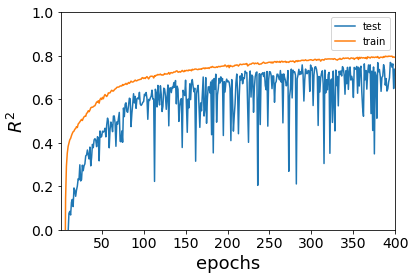

In [2]:
fig, ax = plt.subplots(1,1)
ax.plot(test_R2_all_epochs, label="test")
ax.plot(train_R2_all_epochs, label="train")
ax.set_ylabel('$R^2$',fontsize=18)
ax.set_xlabel('epochs',fontsize=18)
ax.set_xlim([1,epochs])
# ax.set_xlim=[5,8]
# ax.set_ylim=[0,1]
ax.set_ylim([0,1])
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend()
plt.show()